In [15]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
from ipywidgets import Layout, Button, Box
from collections import defaultdict
import ipywidgets as widgets

import json
import os, glob
import pandas as pd
import pandas.io.json as pdjson
import seaborn as sns

sns.set_style("whitegrid")

In [16]:
artifacts_dir = "/etc/skel/sandmark-nightly/parallel/"

In [17]:
bench_files = []

artifacts_path = artifacts_dir.split("/parallel/")[0]

for root, dirs, files in os.walk(artifacts_dir):
    for file in files:
        if file.endswith("_1.orunchrt.summary.bench"):
            f = root.split("/parallel/")
            bench_files.append((os.path.join(root, file)))

In [18]:
benches = defaultdict(list)
for x in bench_files:
    l = x.split("/parallel/")[1]
    d = l.split("/")
    timestamp    = d[0]
    commit       = d[1]
    variant      = d[2]
    variant_root = d[2].split('_')[0]
    variant_stem = d[2].split('_')[1]
    value        = variant_root + '+' + commit + '_' + variant_stem
    benches[timestamp].append(value)
benches = dict(benches)

In [19]:
def f(x): return x

def disp(benches):
    
    def select_commit(timestamp):
        variantW.options = benches[timestamp]
    
    def do_nothing(variant):
        pass
    
    timestamp_list = sorted(list(benches.keys()), reverse=True)
    timestampW = widgets.Dropdown(options=timestamp_list, description='Timestamp', disabled=False)
    timestampD = widgets.interactive(select_commit, timestamp=timestampW)
    
    variantW = widgets.Dropdown(options=benches[timestampW.value], description='Variant', disabled=False)
    variantD = widgets.interactive(do_nothing, variant=variantW)

    items_layout = Layout( width='auto' )
    
    box_layout = Layout(display='flex',
                       flex_flow='row wrap',
                       align_items='flex-start',
                       width='100%')
    items = [timestampD, variantD]
    box = Box(children=items, layout=box_layout)
    display(box)
    return (timestampD, variantD)

def get_filename(t, v):
    timestamp = t.children[0].value
    commit_id = v.children[0].value.split('_')[0].split('+')[-1]
    variant   = v.children[0].value.split('_')[0].split('+')
    variant.pop()
    variant   = '+'.join(variant) + '_' + v.children[0].value.split('_')[1]
    filename  = os.path.join(
        artifacts_path, 
        "parallel", 
        timestamp,
        commit_id,
        variant
        )
    return filename

In [20]:
comparisons = interactive(f, x=widgets.IntText(value=2, 
                                               description='Comparisons', 
                                               disabled=False))
display(comparisons)

interactive(children=(IntText(value=2, description='Comparisons'), Output()), _dom_classes=('widget-interact',…

In [21]:
print(comparisons.result)

2


In [22]:
matrix = [[0 for x in range(3)] for y in range(comparisons.result)]  
    
for i in range(comparisons.result):
    matrix[i][0], matrix[i][1] = disp(benches)

Box(children=(interactive(children=(Dropdown(description='Timestamp', options=('20210610_000004', '20210609_00…

Box(children=(interactive(children=(Dropdown(description='Timestamp', options=('20210610_000004', '20210609_00…

In [23]:
for i in range(comparisons.result):
    matrix[i][2] = get_filename(matrix[i][0], matrix[i][1])

In [24]:
selected_files = []
for i in range (comparisons.result):
    selected_files.append(matrix[i][2])

In [25]:
data_frames = []

for file in selected_files:
    with open(file) as f:
        data = []
        for l in f:
            data.append(json.loads(l))
        df = pd.json_normalize(data)
        value   = file.split('/parallel/')[1]
        date    = value.split('/')[0].split('_')[0]
        commit_id  = value.split('/')[1][:7]
        variant = value.split('/')[2].split('_')[0]
        df["variant"] = variant + '_' + date + '_' + commit_id
        df['name'] = df['name'].apply(lambda x : x.replace(".orunchrt", ""))
        data_frames.append(df)

df = pd.concat (data_frames, sort=False)
df = df.sort_values(['name','time_secs']) 
# Uncomment the following to display all the lines in pandas output
# pd.set_option('display.max_rows', df.shape[0]+1)

In [26]:
def getFastestSequential(df,topic):
    fastest_sequential = {}
    for g in df.groupby(['name']):
        (n,d) = g
        fastest_sequential[n] = min(list(d[topic]))
    return fastest_sequential

def normalize(sdf, mdf, topic):
    frames = []
    fastest_sequential = getFastestSequential(sdf, topic)
    for g in mdf.groupby('name'):        
        (n,d) = g
        n = n.replace('_multicore','')
        d['n'+topic] = 1 / d[topic].div(fastest_sequential[n],axis=0)
        d['b'+topic] = int(fastest_sequential[n])
        frames.append(d)
    return pd.concat(frames)


# Sequential runs
sdf = df.loc[~df['name'].str.contains('multicore',regex=False),:]
throughput_sdf = pd.DataFrame.copy(sdf)

# Multicore runs
mdf = df.loc[df['name'].str.contains('multicore',regex=False),:]
mdf['num_domains'] = mdf['name'].str.split('.',expand=True)[1].str.split('_',expand=True)[0]
mdf['num_domains'] = pd.to_numeric(mdf['num_domains'])
mdf['name'] = mdf['name'].replace('\..*?_','.',regex=True)

mdf = normalize(sdf,mdf,"time_secs")
throughput_mdf = pd.DataFrame.copy(mdf)
# mdf.sort_values(['name','variant','num_domains'])

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

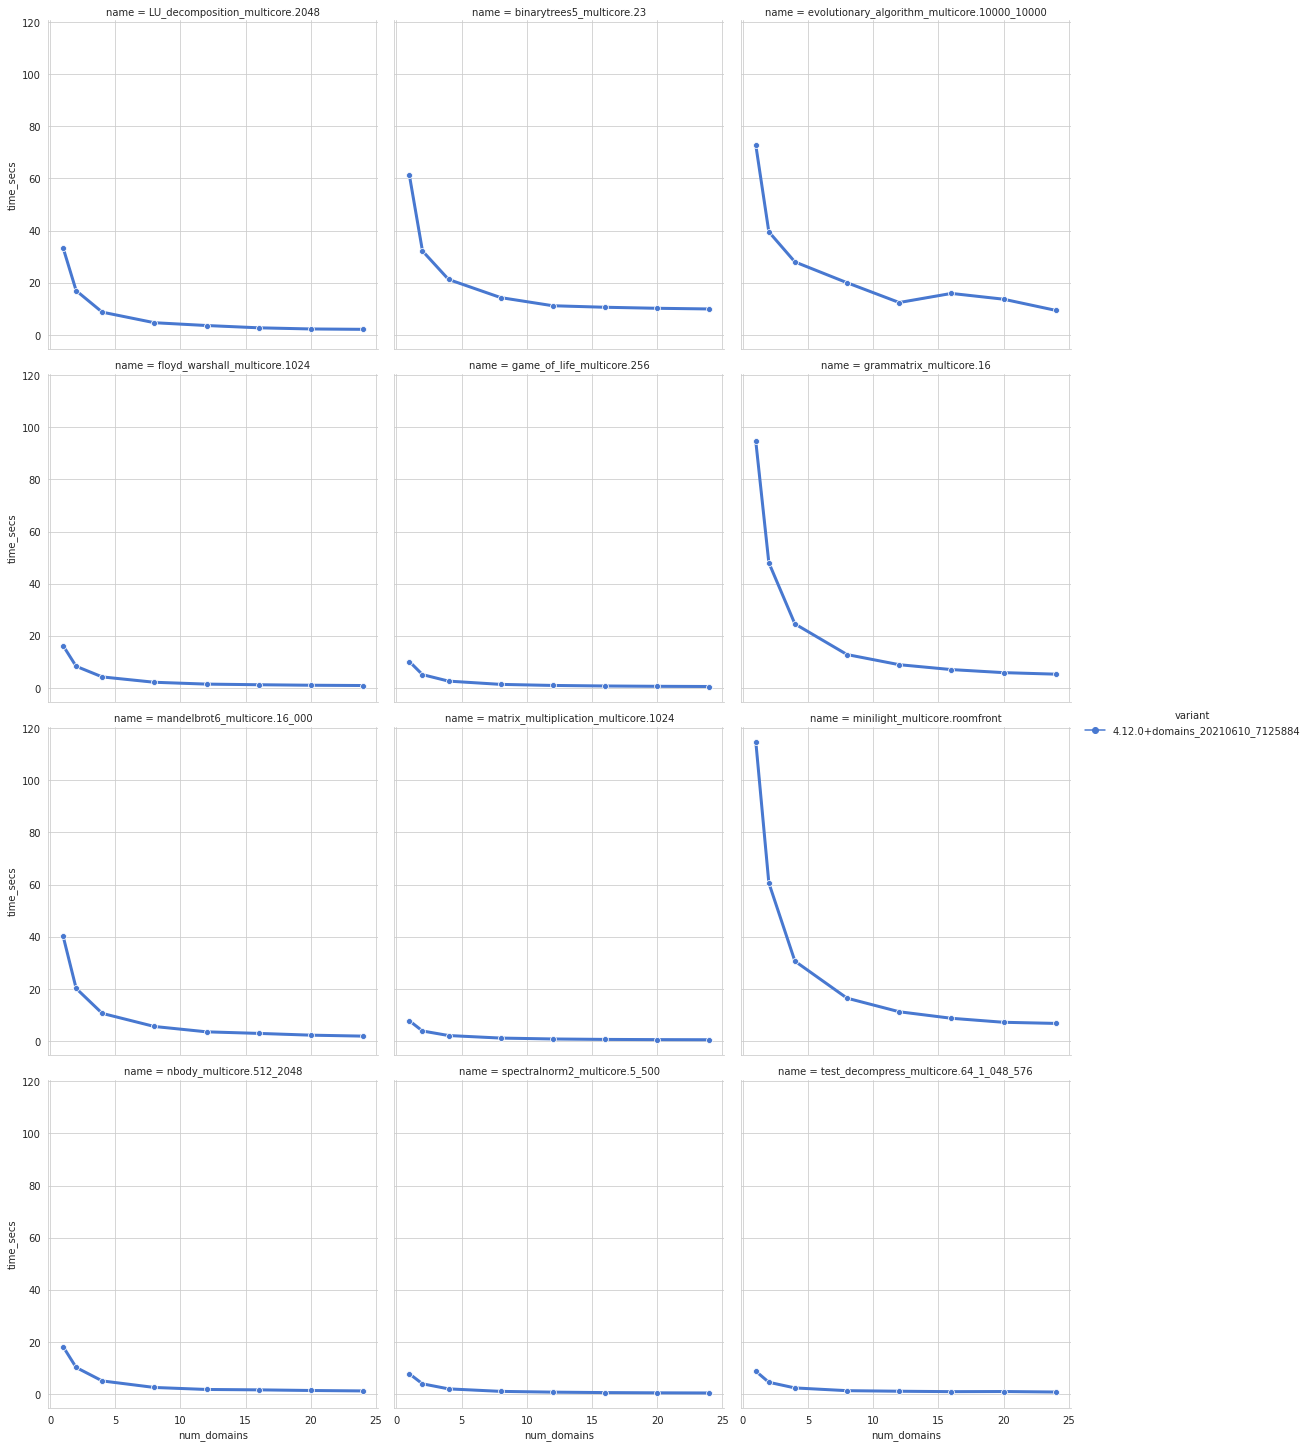

In [27]:
mdf = mdf.sort_values(['name'])
sns.relplot(x='num_domains', y = 'time_secs', hue='variant', col='name',
            data=mdf, kind='line', style='variant', markers=True, col_wrap = 3, 
            lw=3, palette="muted")

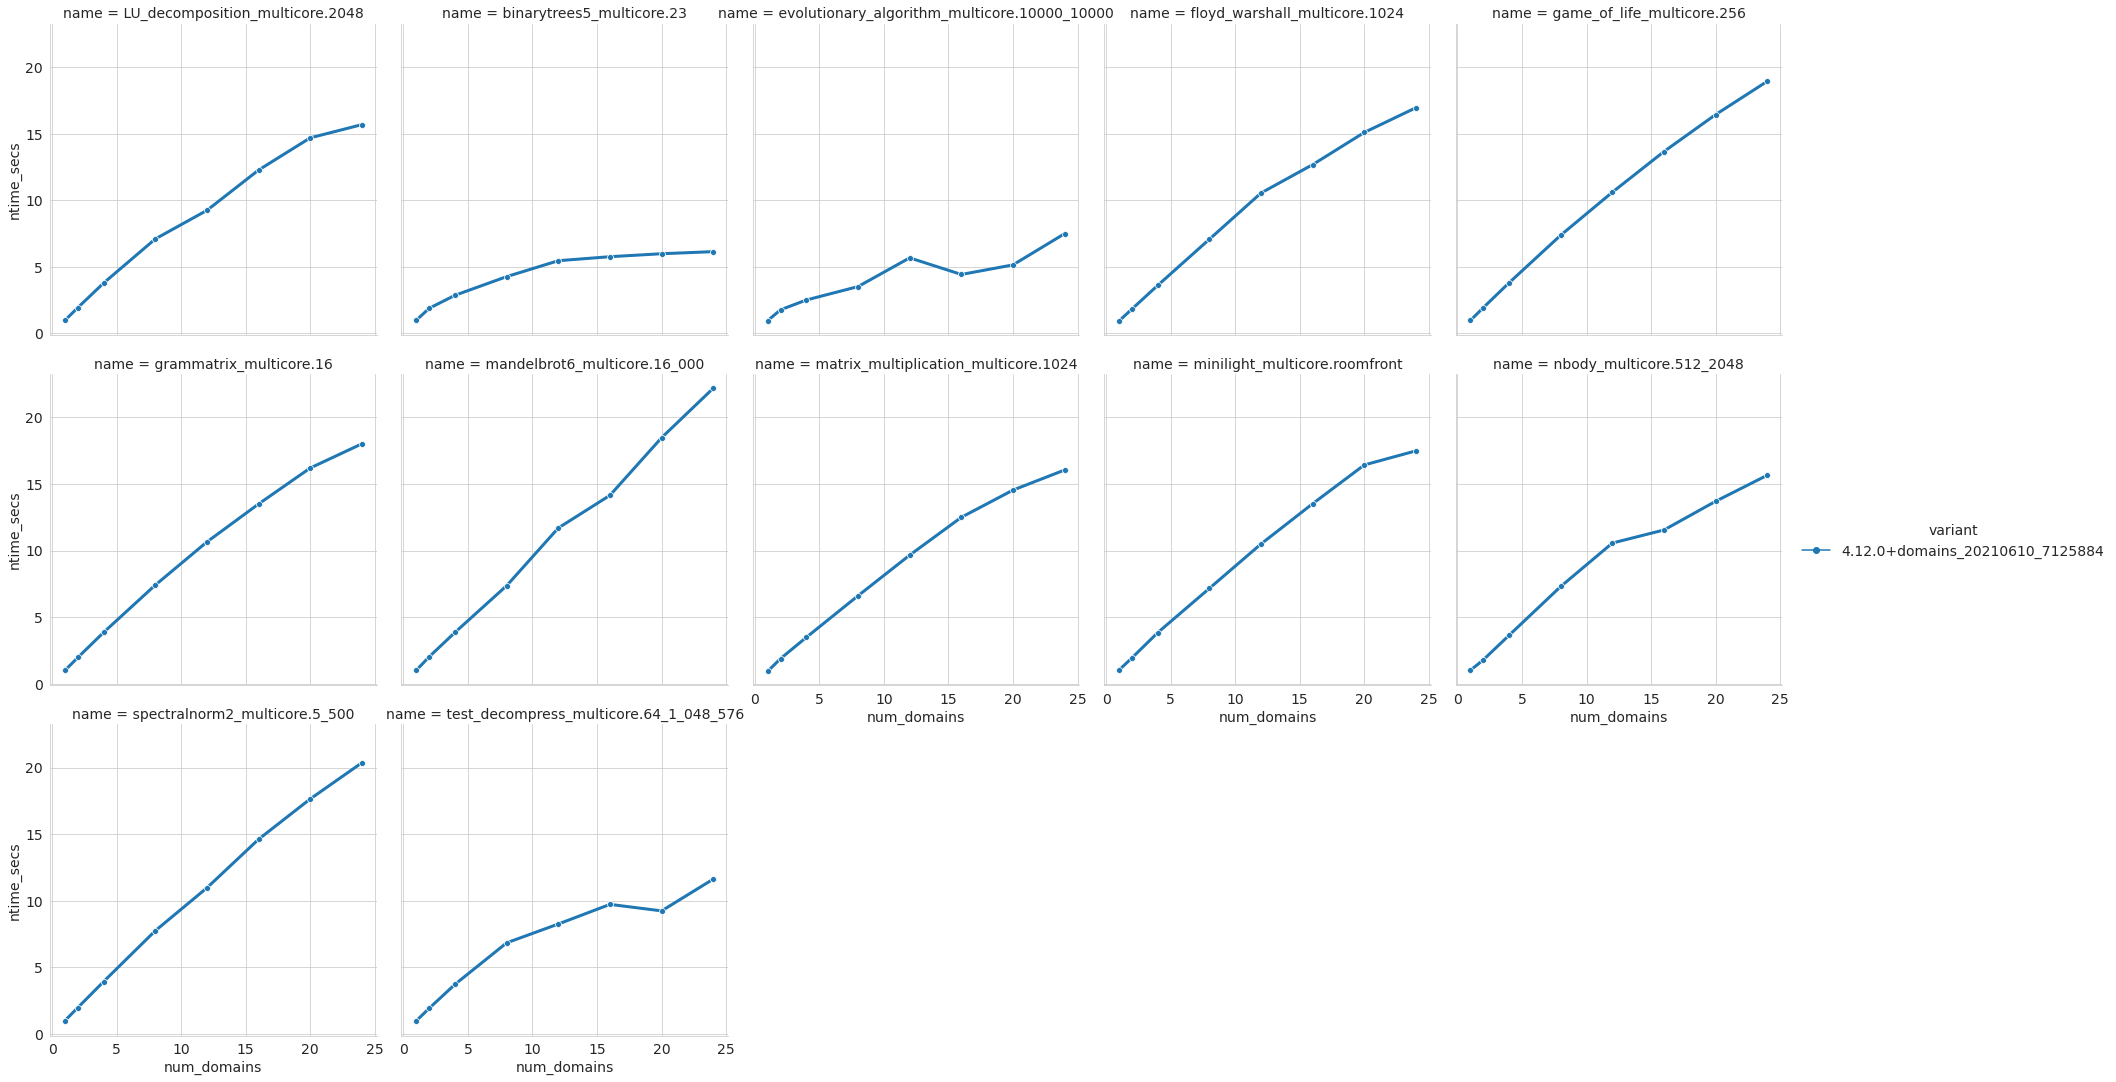

In [28]:
mdf = mdf.sort_values(['name'])
with sns.plotting_context(rc={"font.size":14,"axes.titlesize":14,"axes.labelsize":14,
                              "legend.fontsize":14}):
    sns.relplot(x='num_domains', y = 'ntime_secs', hue='variant', col='name',
                data=mdf, kind='line', style='variant', markers=True, col_wrap = 5, 
                lw=3)
